In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pickle
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import os
import tensorflow as tf

2023-05-12 22:18:33.983880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


After running the /testing_script/trainingDataGeneratorV3.py script to generate additional training images using the live camera feed, the next step is to combine the new data with the original dataset. This should result in higher performance of the predictability of the sign_language_interpreter.py script to take live video feed of sign language and classify the letter. 

The logic to convert the additional training images to a numpy array of images and the corresponding label is below. 

In [2]:
#define relative path to dataset
path_train = '../data/external/sign_mnist_train.csv'
path_test = '../data/external/sign_mnist_test.csv'

#define image resolution 
res = (28,28)

#saving data into pandas dataframes 
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

#training data 
X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

#testing data
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

#letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
#numbers 
numbers = sorted(list(y_train.unique()))
#dictionary of labels 
labels = dict(zip(letters,numbers))

In [3]:
#new images and labels
new_imgs = np.empty((0,784),int)
new_labels = []

#loop through new training data
for root, dirs, files in os.walk('../data/external/newTrainingData/'):
    for file in files:
        #skipping non-image files
        if 'cropped_image' not in file:
            continue
        #taking label from folder name, converting to int, appending to list 
        label = labels[os.path.basename(root)]
        new_labels.append(label)
        #reading img, flatten, append to list
        img = plt.imread(os.path.join(root,file)).reshape(1,-1)
        new_imgs = np.append(new_imgs,img,axis=0)

new_labels = np.array(new_labels)

In [4]:
#printing shapes of new data
print(new_imgs.shape)
print(new_labels.shape)

(2645, 784)
(2645,)


In [5]:
#printing X and y train 
print(X_train.shape)
print(y_train.shape)

(27455, 784)
(27455,)


In [7]:
data = (new_imgs,new_labels)
with open('../data/external/newTrainingData.pkl','wb') as f:
    pickle.dump(data,f)

In [ ]:
#combining new data with training data 
X_train_combined = np.append(new_imgs,X_train.values,axis=0)
y_train_combined = np.append(new_labels,y_train.values)

In [ ]:
#printing shapes
print(X_train_combined.shape)
print(y_train_combined.shape)

(30100, 784)
(30100,)


In [ ]:
#shuffling data
from sklearn.utils import shuffle
X_train_combined, y_train_combined = shuffle(X_train_combined,y_train_combined,random_state=99)

In [ ]:
#convert X_test and y_test to numpy arrays 
X_test = X_test.values
y_test = y_test.values

In [ ]:
#pickling data 
data = (X_train_combined,y_train_combined,X_test,y_test)
with open('../data/external/combined_original_livecamera.pkl','wb') as f:
    pickle.dump(data,f)

The below will use the combined original and live camera image training data to train a neural network. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading pickle data
with open('/content/drive/Shareddrives/SignLanguageData/combined_original_livecamera.pkl','rb') as f:
  x_train,y_train,x_test,y_test = pickle.load(f)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

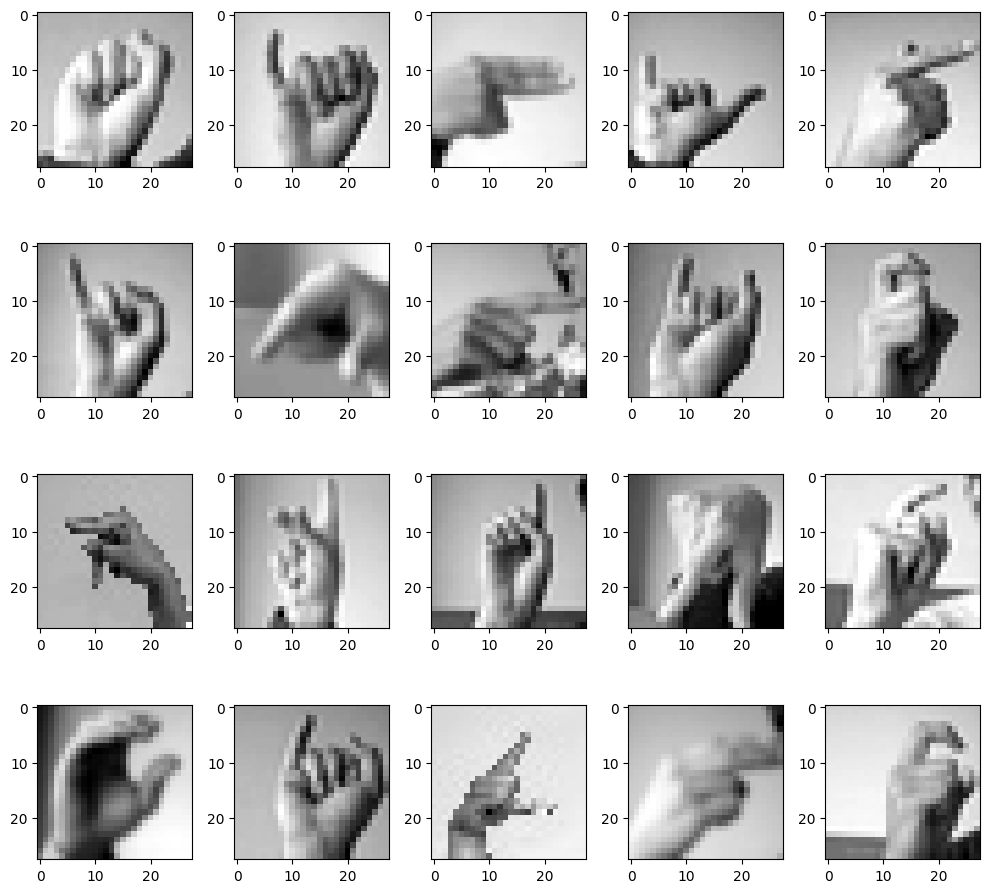

In [ ]:
f, ax = plt.subplots(4,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(4):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout() 

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 75)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 50)      

In [16]:
#reshaping arrays for nn input
x_train = x_train.reshape(x_train.shape[0],28,28)
x_test = x_test.reshape(x_test.shape[0],28,28)

In [ ]:
history = model.fit(x_train,y_train, batch_size = 128 ,epochs = 2 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction], verbose=1)


Epoch 1/2
236/236 [==============================] - 142s 604ms/step - loss: 0.0081 - accuracy: 0.9979 - val_loss: 0.5558 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 2/2
236/236 [==============================] - 133s 566ms/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.3768 - val_accuracy: 0.9011 - lr: 0.0010


In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 7s 30ms/step - loss: 0.3768 - accuracy: 0.9011
Accuracy of the model is -  90.11433124542236 %


In [ ]:
# save the model to an h5 file
model.save('/content/drive/Shareddrives/SignLanguageData/nn_combined_original_livecamera.h5')

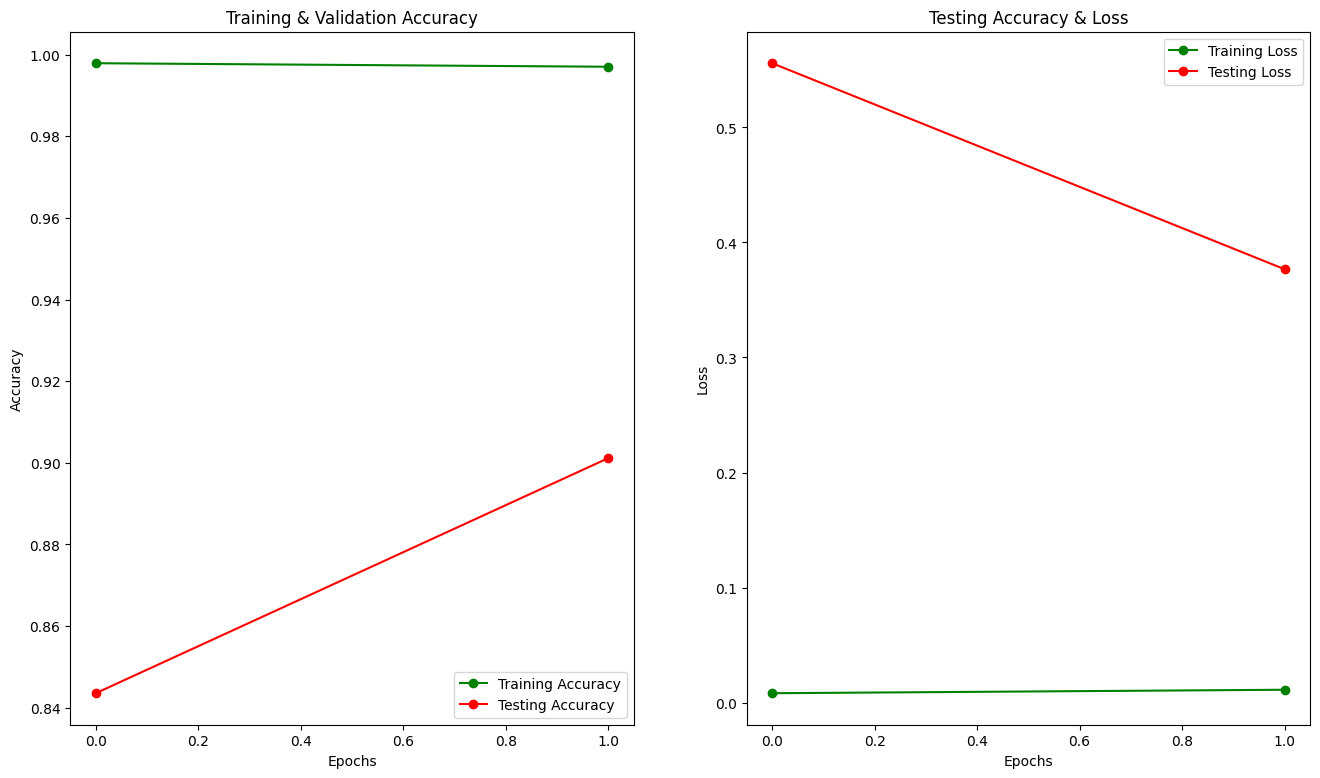

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(16,9)

epochs_acc = [i for i in range(len(history.history['accuracy']))]
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

ax[0].plot(epochs_acc, train_acc, 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs_acc, val_acc, 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

epochs_loss = [i for i in range(len(history.history['loss']))]
train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax[1].plot(epochs_loss, train_loss, 'g-o' , label = 'Training Loss')
ax[1].plot(epochs_loss, val_loss, 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


Augmentation of New Data

In [5]:
with open('/content/drive/Shareddrives/SignLanguageData/newTrainingData.pkl','rb') as f:
  X_train,y_train = pickle.load(f)

In [12]:
#reshaping arrays 
X_train = X_train.reshape(X_train.shape[0],28,28,1)

In [13]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')

X_train: (2645, 28, 28, 1)
y_train: (2645,)


In [15]:
#define image data generator 
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,brightness_range=[0.5, 1.5],fill_mode='nearest')


In [14]:
def data_aug(datagen,X,y):
    #define empty lists to hold augmented data 
    X_augmented = []
    y_augmented = []
    for i in range(X.shape[0]):
        img = X[i]
        label = y[i]
        for j in range(3):
            X_augmented.append(datagen.random_transform(img))
            y_augmented.append(label)
    X_augmented = np.array(X_augmented)

    return X_augmented.reshape(X_augmented.shape[0],28,28),np.array(y_augmented)

In [16]:
#augmented data 
X_train_augmented, y_train_augmented = data_aug(datagen,X_train,y_train)

In [22]:
#reshaping again
X_train = X_train.reshape(X_train.shape[0],28,28)

In [23]:
#concatenate arrays 
X_train_combined = np.concatenate((X_train_augmented,X_train),axis=0)
y_train_combined = np.concatenate((y_train_augmented,y_train),axis=0)

In [24]:
from sklearn.utils import shuffle

X_train_combined,y_train_combined = shuffle(X_train_combined,y_train_combined,random_state=99)

In [26]:
print(f'X_train: {X_train_combined.shape}')
print(f'y_train: {y_train_combined.shape}')

X_train: (10580, 28, 28)
y_train: (10580,)


In [27]:
data = (X_train_combined,y_train_combined)
with open('/content/drive/Shareddrives/SignLanguageData/newTrainingData_augmented.pkl','wb') as f:
  pickle.dump(data,f)